In [1]:
from datasets import load_dataset
from transformers import TrainingArguments, Trainer, AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 加載資料集
dataset = load_dataset("takala/financial_phrasebank", "sentences_allagree", trust_remote_code=True)

# 檢查數據的結構和標籤值
print(dataset['train'][0])  # 查看第一個數據樣本

{'sentence': 'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .', 'label': 1}



Sample data:
                                            sentence  label
0  According to Gran , the company has no plans t...      1
1  For the last quarter of 2010 , Componenta 's n...      2
2  In the third quarter of 2010 , net sales incre...      2
3  Operating profit rose to EUR 13.1 mn from EUR ...      2
4  Operating profit totalled EUR 21.1 mn , up fro...      2

Checking for missing values:
sentence    0
label       0
dtype: int64

Label distribution:
label
1    1391
2     570
0     303
Name: count, dtype: int64


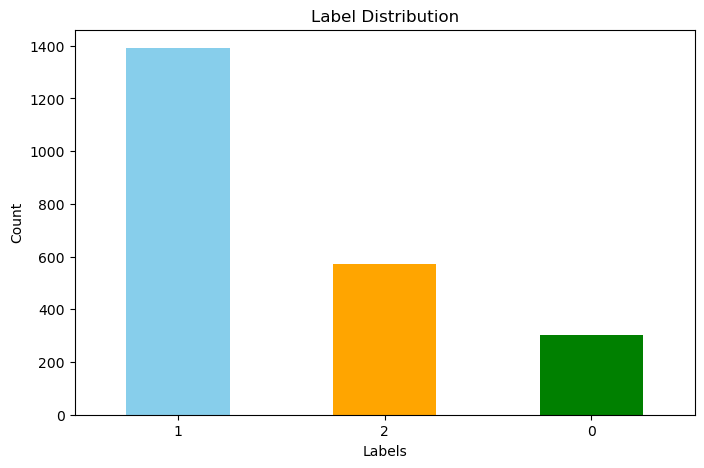

In [3]:
# 將資料集轉換為 pandas DataFrame 進行簡單的檢查
df = pd.DataFrame(dataset['train'])

# EDA: 查看數據分佈
print("\nSample data:")
print(df.head())

# 查看空值
print("\nChecking for missing values:")
print(df.isnull().sum())

# 標籤分佈可視化
print("\nLabel distribution:")
label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title("Label Distribution")
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

In [4]:
# 資料標籤映射
label_map = {"negative": 0, "neutral": 1, "positive": 2}

# 分割訓練與測試集
dataset = dataset["train"].train_test_split(test_size=0.2)

print(dataset['train'][:10])

{'sentence': ['Net sales of Finnish Sanoma Learning & Literature , of Finnish media group Sanoma , decreased by 3.6 % in January-June 2009 totalling EUR 162.8 mn , down from EUR 168.8 mn in the corresponding period in 2008 .', "Aspo 's Group structure and business operations are continually developed without any predefined schedules .", 'The medium-term operative targets of the company remain unchanged .', 'Under the agreement , Larox will transfer 10 employees within engineering and documentation related to delivery projects and product maintenance in Finland to Etteplan as of January 1 , 2007 .', 'Apartments of YIT Home may be purchased in 5 regions of Russia , where YIT subsidiaries carry out their activities : Moscow and Moscow region , St. Petersburg , Ekaterinburg , Kazan and Rostov-on-Don .', "`` These developments partly reflect the government 's higher activity in the field of dividend policy . ''", 'Fortum had previously bought the state-held stake in TGK-10 from RAO UES duri

In [5]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import accelerate
print("Accelerate 版本:", accelerate.__version__)


Accelerate 版本: 1.1.1


In [8]:
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

GPU 0: NVIDIA GeForce RTX 3050


In [9]:
# 初始化分詞器
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# 資料分詞與編碼
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

encoded_dataset = dataset.map(tokenize_function, batched=True)
encoded_dataset = encoded_dataset.remove_columns(["sentence"])
encoded_dataset = encoded_dataset.rename_column("label", "labels")
encoded_dataset.set_format("torch")

# 初始化模型
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

# 訓練參數設置
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    run_name="financial_sentiment_analysis",
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 初始化 Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    data_collator=data_collator,
)

# 訓練模型
trainer.train()


Map:   0%|          | 0/1811 [00:00<?, ? examples/s]

Map:   0%|          | 0/453 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1359 [00:00<?, ?it/s]

{'loss': 1.1614, 'grad_norm': 23.086448669433594, 'learning_rate': 1.985283296541575e-05, 'epoch': 0.02}
{'loss': 0.9171, 'grad_norm': 15.801631927490234, 'learning_rate': 1.9705665930831493e-05, 'epoch': 0.04}
{'loss': 0.7591, 'grad_norm': 5.620291709899902, 'learning_rate': 1.9558498896247242e-05, 'epoch': 0.07}
{'loss': 0.7821, 'grad_norm': 7.368476390838623, 'learning_rate': 1.9411331861662988e-05, 'epoch': 0.09}
{'loss': 0.7342, 'grad_norm': 9.257476806640625, 'learning_rate': 1.9264164827078734e-05, 'epoch': 0.11}
{'loss': 0.5369, 'grad_norm': 5.847714900970459, 'learning_rate': 1.9116997792494483e-05, 'epoch': 0.13}
{'loss': 0.5475, 'grad_norm': 2.054258108139038, 'learning_rate': 1.896983075791023e-05, 'epoch': 0.15}
{'loss': 0.4779, 'grad_norm': 9.223369598388672, 'learning_rate': 1.8822663723325975e-05, 'epoch': 0.18}
{'loss': 0.2985, 'grad_norm': 3.670071601867676, 'learning_rate': 1.8675496688741724e-05, 'epoch': 0.2}
{'loss': 0.561, 'grad_norm': 5.286404609680176, 'learnin

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.1633351594209671, 'eval_runtime': 10.7022, 'eval_samples_per_second': 42.328, 'eval_steps_per_second': 5.326, 'epoch': 1.0}
{'loss': 0.0035, 'grad_norm': 0.03371059522032738, 'learning_rate': 1.3230316409124357e-05, 'epoch': 1.02}
{'loss': 0.0085, 'grad_norm': 0.0217888280749321, 'learning_rate': 1.3083149374540105e-05, 'epoch': 1.04}
{'loss': 0.0033, 'grad_norm': 0.06121065467596054, 'learning_rate': 1.293598233995585e-05, 'epoch': 1.06}
{'loss': 0.3954, 'grad_norm': 0.8409738540649414, 'learning_rate': 1.2788815305371598e-05, 'epoch': 1.08}
{'loss': 0.0855, 'grad_norm': 0.14960232377052307, 'learning_rate': 1.2641648270787345e-05, 'epoch': 1.1}
{'loss': 0.185, 'grad_norm': 0.08310596644878387, 'learning_rate': 1.2494481236203091e-05, 'epoch': 1.13}
{'loss': 0.1399, 'grad_norm': 0.04592049494385719, 'learning_rate': 1.2347314201618839e-05, 'epoch': 1.15}
{'loss': 0.256, 'grad_norm': 0.04472832381725311, 'learning_rate': 1.2200147167034586e-05, 'epoch': 1.17}
{'loss': 0

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.12121820449829102, 'eval_runtime': 10.6447, 'eval_samples_per_second': 42.557, 'eval_steps_per_second': 5.355, 'epoch': 2.0}
{'loss': 0.0013, 'grad_norm': 0.006402687169611454, 'learning_rate': 6.607799852832966e-06, 'epoch': 2.01}
{'loss': 0.157, 'grad_norm': 0.08738812059164047, 'learning_rate': 6.460632818248713e-06, 'epoch': 2.03}
{'loss': 0.0159, 'grad_norm': 40.28721618652344, 'learning_rate': 6.31346578366446e-06, 'epoch': 2.05}
{'loss': 0.0017, 'grad_norm': 0.06137020140886307, 'learning_rate': 6.1662987490802066e-06, 'epoch': 2.08}
{'loss': 0.1389, 'grad_norm': 0.12391295284032822, 'learning_rate': 6.019131714495954e-06, 'epoch': 2.1}
{'loss': 0.1055, 'grad_norm': 0.04534090682864189, 'learning_rate': 5.871964679911701e-06, 'epoch': 2.12}
{'loss': 0.0015, 'grad_norm': 0.07395631819963455, 'learning_rate': 5.7247976453274465e-06, 'epoch': 2.14}
{'loss': 0.0011, 'grad_norm': 0.02031750977039337, 'learning_rate': 5.577630610743194e-06, 'epoch': 2.16}
{'loss': 0.01

  0%|          | 0/57 [00:00<?, ?it/s]

{'eval_loss': 0.12521818280220032, 'eval_runtime': 10.6622, 'eval_samples_per_second': 42.487, 'eval_steps_per_second': 5.346, 'epoch': 3.0}
{'train_runtime': 534.3508, 'train_samples_per_second': 10.167, 'train_steps_per_second': 2.543, 'train_loss': 0.1724962815333972, 'epoch': 3.0}


TrainOutput(global_step=1359, training_loss=0.1724962815333972, metrics={'train_runtime': 534.3508, 'train_samples_per_second': 10.167, 'train_steps_per_second': 2.543, 'total_flos': 1429495198516224.0, 'train_loss': 0.1724962815333972, 'epoch': 3.0})

In [10]:
# 測試數據
test_texts = [
    "The company's profit has increased significantly this quarter.",
    "The increase in costs negatively affected the revenue.",
    "The company’s performance remained stable.",
]

# 分詞與編碼
test_encodings = tokenizer(test_texts, truncation=True, padding=True, return_tensors="pt").to("cuda")

# 模型推論
model.eval()
outputs = model(**test_encodings)

# 取得預測結果
preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

# 將數字標籤轉換為文字標籤
label_map_reverse = {v: k.capitalize() for k, v in label_map.items()}
predicted_labels = [label_map_reverse[pred] for pred in preds]

# 打印結果
print(predicted_labels)

['Positive', 'Negative', 'Positive']
